# Mejora del modelo ML
### Andrés Nieto Guadarrama

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split,cross_validate
from sklearn.metrics import mean_squared_error
from ipywidgets import interact,interact_manual
from IPython.display import display
from numpy.random import seed, randn
from sklearn.preprocessing import PolynomialFeatures

In [35]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

### Base de datos: Casas en Seattle

In [36]:
housing=pd.read_csv(r"train.csv")

Crearemos un pipeline y limpiaremos la base convertiendo a variable categórica 'label_bin'.

### Modelo ML

In [37]:
column_selector = ColumnTransformer(
    [("label_bin", OneHotEncoder(sparse=False), ["MSZoning", "SaleCondition"]),
     ("numeric", SimpleImputer(), make_column_selector(dtype_include="float"))]
)

pipe = Pipeline([
    ("select_cols", column_selector),
    ("lasso", Lasso(alpha=0.1, tol=0.5))
])

Tomemos una porción de los datos (20%) para probar el modelo, y el resto para entrenarlo

In [38]:
train, test = train_test_split(housing, test_size=0.2, random_state=2718)
xtrain, ytrain = train.drop("SalePrice", axis=1), train["SalePrice"]

cv = cross_validate(pipe, xtrain, ytrain, cv=5, scoring=["r2", "neg_mean_absolute_error"])
r2 = cv["test_r2"]
mae = -cv["test_neg_mean_absolute_error"]

Debemos mejorar la siguietne $R^2$:

In [39]:
print(f"mean r2: {r2.mean():0.2f}")
print(f"mean MAE : {mae.mean():0.2f}")

mean r2: 0.44
mean MAE : 41749.60


In [40]:
from sklearn.model_selection import GridSearchCV

alphas = [1/i for i in range(1, 11)]
grid = {
    "lasso__alpha": [0.1 * 10 ** (i/2) for i in range(1, 11)],
}

In [41]:
%%time
gsearch = GridSearchCV(pipe, grid, scoring="neg_mean_absolute_error",
                       return_train_score=True, cv=10)
gsearch.fit(xtrain, ytrain)
cvres = gsearch.cv_results_

Wall time: 1.92 s


In [42]:
train_score = np.sqrt(-cvres["mean_train_score"])
test_score = np.sqrt(-cvres["mean_test_score"])

cv = cross_validate(gsearch.best_estimator_, xtrain, ytrain, cv=5, scoring=["r2", "neg_mean_absolute_error"])
r2 = cv["test_r2"]
mae = -cv["test_neg_mean_absolute_error"]

### A superar:

In [43]:
print(f"mean r2: {r2.mean():0.2f}")
print(f"mean MAE : {mae.mean():0.2f}")

mean r2: 0.44
mean MAE : 41620.65


### Mejora del modelo

Exploremos un poco la relación entre las variables explicativas y la variable respuesta

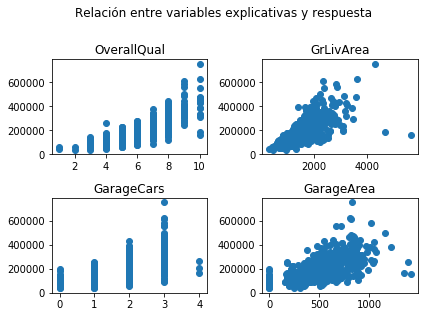

In [44]:
X=pd.concat([xtrain,ytrain],axis=1)
R2=X.corr()[list(X.keys())[-1]]
R2=R2.sort_values(ascending=False)
L=R2.index[1:5]
fig, ax = plt.subplots(2, 2)
plt.title('Window Title')
ax=ax.ravel()
for axi,l in zip(ax,L):
    axi.scatter(xtrain[l],ytrain)
    axi.set_title(l)
fig.suptitle('Relación entre variables explicativas y respuesta',y=1.09,x=.525)
plt.tight_layout()

Proponemos una regresión polinomial entre la variable respuesta y GrLivArea, que es la columna con datos continuos para la que ytrain está más correlacionada.

In [51]:
import ipywidgets as widgets

X_exp=xtrain.copy()
X_exp=X[L[1]]


def make_pipe(deg,x,y):
    pipe=Pipeline([
            ("Polytransform",PolynomialFeatures(degree=deg,include_bias=False)),
            ("linear_model",LinearRegression()),
    ])
    
    pipe.fit(x[:,np.newaxis],y)
    
    return pipe

def gbase(deg):
    x,y=X_exp,ytrain
    pipe=make_pipe(deg,x,y)
    rango_x=np.linspace(x.min(),x.max(),len(x))
    plt.title(f"Modelo polinomial de grado {deg}")
    plt.plot(rango_x,pipe.predict(rango_x.reshape(len(x),1)),c='r',label='modelo')
    r_cuad=pipe.score(np.array(x).reshape(len(x),1),np.array(y).reshape(len(x),1))
    plt.text(x=2250,y=125000,s=f"{'Coef. de determinación $R^2$'}: {round(r_cuad,2)}")
    plt.legend()
    plt.show()

slider_deg=widgets.IntSlider(
    value=2,
    min=1,
    max=30,
    step=1,
    description='Grado:',
    height=5,
    width=5,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

w=interact_manual(gbase,deg=slider_deg) 
display(w)


interactive(children=(IntSlider(value=2, continuous_update=False, description='Grado:', max=30, min=1), Button…

<function __main__.gbase(deg)>

# Segundo modelo: Regresión logística

In [46]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Creamos una variable categórica y nos quedamos con la variable tipo 'float' más correlacionada con la respuesta.

column_selector = ColumnTransformer(
    [("label_bin", OneHotEncoder(sparse=False), [L[0]]),
     ("numeric", SimpleImputer(), make_column_selector(pattern=L[1]))]
)


#Definimos un modelo de regresión logística

pipe2 = Pipeline([
    ("select_cols", column_selector),    
    ("logistic_regression", LogisticRegression())
])

#Dividimos la muestra para quedarnos con una parte para entrenar al modelo:

train2, test2 = train_test_split(housing, test_size=0.3, random_state=2718)
xtrain2,ytrain2 = train2.drop("SalePrice", axis=1),train2["SalePrice"]

#Entrenamos al modelo:

pipe2.fit(xtrain2, ytrain2)

#Veamos qué tal nos fue en términos del coeficiente de determinación R^2

cv = cross_validate(pipe2, xtrain2, ytrain2, cv=5, scoring=["r2", "neg_mean_absolute_error"])
r22 = cv["test_r2"]

C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERA

In [47]:
print(f"mean r2: {r22.mean():0.2f}")

if r22.mean()>r2.mean():
    print("El modelo de regresión logística también mejora un poco el modelo inicial.")

mean r2: 0.46
El modelo de regresión logística también mejora un poco el modelo inicial.


# Tarea Conceptual:

Considerar la función sigmoide: 
$$\sigma(a)=\frac{1}{1+e^{-a}}$$
Por demostrar: 
$$\frac{d\sigma(a)}{da}=\sigma(a)(1-\sigma(a))$$    

### Demostración:

Notar que:
$$\frac{d\sigma(a)}{da}\,=\,\frac{e^{-a}}{(1+e^{-a})^2} \,=\, \frac{e^{-a}}{(1+e^{-a})}\,\cdot\,\frac{1}{(1+e^{-a})}\,=\, \frac{e^{-a}}{(1+e^{-a})}\,\cdot\,\sigma(a).$$

Sin emabargo, 

$$(1-\sigma(a))\,=\,1-\frac{1}{1+e^{-a}}\,=\,\frac{1+e^{-a}-1}{1+e^{-a}}\,=\,\frac{e^{-a}}{1+e^{-a}}.$$
Con lo cual, 
$$\frac{d\sigma(a)}{da}\,=\,\frac{e^{-a}}{(1+e^{-a})}\,\cdot\,\sigma(a)\,=\,\sigma(a)(1-\sigma(a)). \,\,\,QED.$$ 